In [30]:
import os
import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
from SRtools import samples_utils as su
from SRtools import SR_hetro as srh
from SRtools import joint_posterior as jp
import emcee

In [31]:
parallel =True


# Define configurations to run with, time scales (for life span calculations)

In [32]:
paths = ['mice_F','mice_M','yeast','ecoli','cats_vp_M', 'cats_vp_F',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        'Sweden_M_1910_hetro','Sweden_F_1910_hetro','Denmark_M_1900_hetro','Denmark_M_1890_hetro',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        'Denmark_F_1890_hetro',
        'celegans','Denmark_F_1900_hetro','Guiniea_pig_VC']

In [33]:
time_scales ={
   'mice_F': 'weeks',
   'mice_M': 'weeks',
   'yeast': 'generations',
   'ecoli': 'hours',
   'cats_vp_M': 'years',
   'cats_vp_F': 'years',
   'drosophila_853': 'days',
   'drosophila_707': 'days',
   'drosophila_441': 'days',
   'drosophila_217': 'days',
   'Sweden_M_1910_hetro': 'years',
   'Sweden_F_1910_hetro': 'years',
   'Denmark_M_1900_hetro': 'years',
   'Denmark_M_1890_hetro': 'years',
   'Staffy_vetCompass': 'years',
   'Labradors_vetCompass': 'years',
   'Jack_Russell_vetCompass': 'years',
   'German_Shepherd_vetCompass': 'years',
   'Denmark_F_1890_hetro': 'years',
   'celegans': 'generations',
   'Denmark_F_1900_hetro': 'years',
   'Guiniea_pig_VC': 'years',

}

# Run simulations to calculate lifespans without external hazard

In [1]:
posteriors ={}
sims ={}
MLs= {}
for path in paths:
    post_path = path+'_post.csv'
    post_path = os.path.join('posteriors',post_path)
    post = su.Posterior.load_from_file(post_path)
    
    #########################################################
    config =post.config_params
    npeople = config['npeople']
    t_end = config['t_end']
    nwalkers = config['nwalkers']
    nsteps = config['nsteps']
    num_mcmc_steps = config['n_mcmc_steps']
    metric = config['metric']
    time_range = config.get('time_range',None)
    time_step_multiplier = config['time_step_multiplier']
    data_file = config.get('data_file',None)
    seed_file = config.get('seed_file',None)
    variations = config.get('variations')
    prior = config.get('prior')
    transform = config.get('transform',True)
    index = config.get('index',1)
    external_hazard = config.get('external_hazard',None)
    if isinstance(external_hazard, str):
        external_hazard = ast.literal_eval(external_hazard)
    hetro = config.get('hetro', False)
    submission_folder = config['submission_folder']
    test_mode = config.get('test', False)
    n_tests = config.get('n_tests', 1)
    ndims = config.get('ndims', 4)
    dt = config.get('dt',1)
    nbins = int(config.get('nbins',100))
    TIME_UNIT = config.get('TIME_UNIT','days')
    TIME_UNIT = time_scales[path]

    if TIME_UNIT == 'days':
        scale = 1
    elif TIME_UNIT == 'hours':
        scale = 1/24
    elif TIME_UNIT == 'years':
        scale = 365
    elif TIME_UNIT == 'weeks':
        scale = 7
    elif TIME_UNIT == 'generations':
        scale = 1/8
    


    best_theta = srmc.inv_transform(post.best_raw_sample() )
    
    best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=None,hetro =hetro,parallel=parallel)
    sims[path] = best_sim
    MLs[path] = best_sim.median_lifetime*scale
    print(path,MLs[path],MLs[path]/scale)
    rescale_map = [scale**2,scale,scale,1,1]
    post.bins = 100
    posteriors[path] = post.rescale(rescale_map)

NameError: name 'paths' is not defined

sanity check

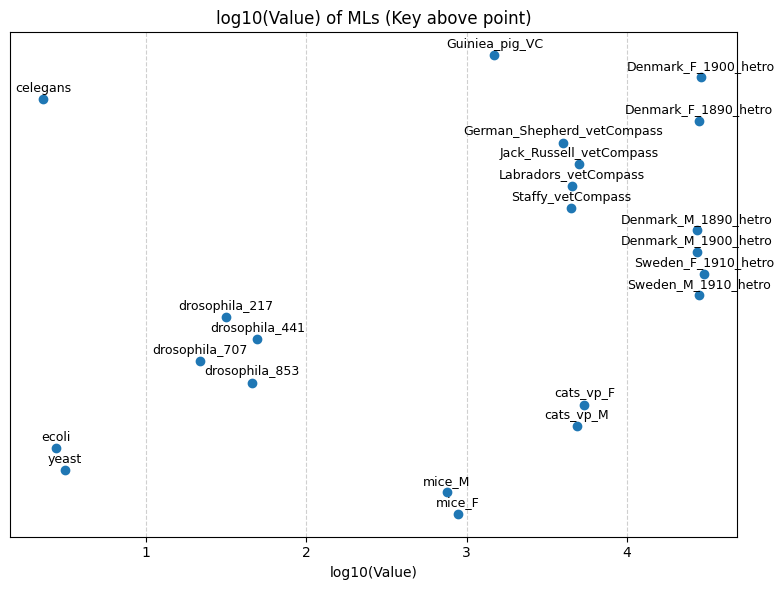

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
x_vals = list(MLs.values())
y_labels = list(MLs.keys())
log_x_vals = np.log10(x_vals)

# Plot log10(value) on x-axis, y-axis has no meaning (arbitrary position)
y_dummy = np.arange(len(log_x_vals))
plt.scatter(log_x_vals, y_dummy)

# Annotate each point with its label above the point
for x, y, label in zip(log_x_vals, y_dummy, y_labels):
    plt.text(x, y + 0.2, str(label), ha='center', va='bottom', fontsize=9, rotation=0)

plt.xlabel('log10(Value)')
plt.yticks([])  # Hide y-axis ticks, since y has no meaning
plt.ylabel('')
plt.title('log10(Value) of MLs (Key above point)')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Removing duplicate samples and lowest 5% of remaining samples. 
This printout is used in supplamentary table 6

In [ ]:
precentile = 5
print('precentile',precentile)
sample_sets ={}
for path in paths:
    raw_samples = posteriors[path].samples
    raw_lnprobs = posteriors[path].lnprobs

    # remove duplicate samples, and their corresponding lnprobs
    unique_samples, unique_indices = np.unique(raw_samples, axis=0, return_index=True)
    raw_samples = unique_samples
    raw_lnprobs = raw_lnprobs[unique_indices]

    # take the precentile of the lnprobs
    lnprobs_precentile = np.percentile(raw_lnprobs, precentile)

    # take the samples that have lnprobs greater than the precentile
    sample_indices = np.where(raw_lnprobs > lnprobs_precentile)[0]
    samples = raw_samples[sample_indices]
    lnprobs = raw_lnprobs[sample_indices]

    samples =np.array([srmc.inv_transform(sample) for sample in samples])
    sample_sets[path] = samples[:,:4]
    print(path,sample_sets[path].shape)
    
    
    

precentile 5
mice_F (60230, 4)
mice_M (107871, 4)
yeast (23619, 4)
ecoli (16847, 4)
cats_vp_M (1331, 4)
cats_vp_F (1315, 4)
drosophila_853 (208288, 4)
drosophila_707 (396648, 4)
drosophila_441 (77090, 4)
drosophila_217 (608038, 4)
Sweden_M_1910_hetro (1998, 4)
Sweden_F_1910_hetro (777, 4)
Denmark_M_1900_hetro (2199, 4)
Denmark_M_1890_hetro (2490, 4)
Staffy_vetCompass (3359, 4)
Labradors_vetCompass (8851, 4)
Jack_Russell_vetCompass (8346, 4)
German_Shepherd_vetCompass (54351, 4)
Denmark_F_1890_hetro (2529, 4)
celegans (45497, 4)
Denmark_F_1900_hetro (1266, 4)
Guiniea_pig_VC (1117621, 4)


# Define ANOVA function

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')

def perform_anova_analysis(df, dependent_var='log_MLs', title="ANOVA Analysis", verbose=True):
    """
    Perform ANOVA analysis with all permutations to find optimal ordering.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing log_eta, log_beta, log_epsilon, log_xc, and dependent_var columns
    dependent_var : str
        Name of the dependent variable column (default: 'log_MLs')
    title : str
        Title for the analysis output
    verbose : bool
        Whether to print detailed output (default: True)
        
    Returns:
    --------
    dict : Dictionary containing best_result, final_model, final_anova, results_df, and variance explained
    """
    vars_list = ['log_eta', 'log_beta', 'log_epsilon', 'log_xc']
    var_names = ['eta', 'beta', 'epsilon', 'xc']
    
    if verbose:
        print(f"\n{title}")
        print("="*80)
        print(f"Testing all permutations to find optimal ordering...")
        print(f"Fitting to {dependent_var}")
        print("="*80)
    
    # Generate all permutations
    all_perms = list(permutations(range(len(vars_list))))
    results_list = []
    
    for perm_idx, perm in enumerate(all_perms):
        # Get the variable order for this permutation
        perm_vars = [vars_list[i] for i in perm]
        perm_names = [var_names[i] for i in perm]
        
        # Build formula with variables in this order
        formula = f'{dependent_var} ~ {" + ".join(perm_vars)}'
        
        # Fit model and get ANOVA
        model = ols(formula, data=df).fit()
        anova_table = anova_lm(model, typ=1)  # Type I (sequential) ANOVA
        
        # Extract sum of squares
        ss_values = anova_table['sum_sq'].values
        
        # Store results
        result = {
            'permutation': perm,
            'var_order': perm_names,
            'formula': formula,
            'sumsq01': ss_values[0],
            'sumsq02': ss_values[1],
            'sumsq03': ss_values[2],
            'sumsq04': ss_values[3],
            'sumsq05': ss_values[4],  # residual
            'p01': anova_table['PR(>F)'].values[0],
            'p02': anova_table['PR(>F)'].values[1],
            'p03': anova_table['PR(>F)'].values[2],
            'p04': anova_table['PR(>F)'].values[3],
            'p05': anova_table['PR(>F)'].values[4],
            'r_squared': model.rsquared
        }
        results_list.append(result)
    
    # Convert to DataFrame and sort by sumsq01, sumsq02, etc. (decreasing)
    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values(
        by=['sumsq01', 'sumsq02', 'sumsq03', 'sumsq04', 'sumsq05'],
        ascending=False
    )
    
    if verbose:
        print(f"\nTotal permutations tested: {len(results_df)}")
        print("\nBest ordering (maximizes sum of squares):")
    
    best_result = results_df.iloc[0]
    
    if verbose:
        print(f"  Order: {', '.join(best_result['var_order'])}")
        print(f"  Sum Sq values: {best_result['sumsq01']:.2e}, {best_result['sumsq02']:.2e}, "
              f"{best_result['sumsq03']:.2e}, {best_result['sumsq04']:.2e}, {best_result['sumsq05']:.2e}")
        
        # Now perform final ANOVA with the best ordering
        print("\n" + "="*80)
        print("Final ANOVA with best ordering:")
        print("="*80)
    
    best_order = best_result['var_order']
    best_vars = [vars_list[var_names.index(v)] for v in best_order]
    best_formula = f'{dependent_var} ~ {" + ".join(best_vars)}'
    
    final_model = ols(best_formula, data=df).fit()
    final_anova = anova_lm(final_model, typ=1)
    
    if verbose:
        print(f"\nFormula: {best_formula}")
        print("\nANOVA Table (Type I - Sequential):")
        print(final_anova)
        print(f"\nOverall R²: {final_model.rsquared:.4f}")
        print(f"Adjusted R²: {final_model.rsquared_adj:.4f}")
        
        # Calculate variance explained by each parameter and residual
        print("\n" + "="*80)
        print("Variance Explained by Each Parameter (Sequential):")
        print("="*80)
    
    # Calculate total sum of squares (SST)
    y_mean = df[dependent_var].mean()
    sst = ((df[dependent_var] - y_mean) ** 2).sum()
    
    # Get sum of squares from ANOVA table
    anova_ss = final_anova['sum_sq']
    
    # Calculate variance explained by each parameter
    variance_explained = {}
    for i, param in enumerate(best_vars):
        ss_param = anova_ss[param]
        prop_var = ss_param / sst
        p_val = final_anova.loc[param, 'PR(>F)']
        variance_explained[best_order[i]] = {
            'sum_sq': ss_param,
            'proportion': prop_var,
            'percentage': prop_var * 100,
            'p_value': p_val,
            'position': i + 1  # 1-indexed position in the ordering
        }
    
    # Residual variance
    ss_residual = anova_ss['Residual']
    prop_residual = ss_residual / sst
    variance_explained['Residual'] = {
        'sum_sq': ss_residual,
        'proportion': prop_residual,
        'percentage': prop_residual * 100
    }
    
    if verbose:
        print(f"\nTotal Sum of Squares (SST): {sst:.2e}\n")
        print(f"Variance Explained (in order: {', '.join(best_order)}):")
        print("-" * 80)
        
        for var_name in best_order:
            var_info = variance_explained[var_name]
            print(f"{var_name:20s}: {var_info['sum_sq']:15.2e} ({var_info['percentage']:6.2f}% of total variance, p={var_info['p_value']:.4e})")
        
        print(f"{'Residual':20s}: {variance_explained['Residual']['sum_sq']:15.2e} ({variance_explained['Residual']['percentage']:6.2f}% of total variance)")
        
        # Summary
        total_explained = sum([variance_explained[v]['proportion'] for v in best_order])
        print(f"\n{'Total Explained':20s}: {total_explained*100:6.2f}%")
        print(f"{'Residual':20s}: {variance_explained['Residual']['percentage']:6.2f}%")
        print(f"{'Total':20s}: {(total_explained + variance_explained['Residual']['proportion'])*100:6.2f}%")
    
    return {
        'best_result': best_result,
        'final_model': final_model,
        'final_anova': final_anova,
        'results_df': results_df,
        'best_order': best_order,
        'best_vars': best_vars,
        'variance_explained': variance_explained,
        'most_significant': best_order[0]  # First variable in best ordering
    }


# Test on one random sample, remove the set seed if want to see different random samples

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Randomly sample one row from each path's sample_set
sampled_data = []
for path in paths:
    n_samples = sample_sets[path].shape[0]
    random_idx = np.random.randint(0, n_samples)
    sample = sample_sets[path][random_idx]
    eta, beta, epsilon, xc = sample
    
    # Get corresponding MLs value
    ml_value = MLs[path]
    
    sampled_data.append({
        'path': path,
        'eta': eta,
        'beta': beta,
        'epsilon': epsilon,
        'xc': xc,
        'log_eta': np.log(eta),
        'log_beta': np.log(beta),
        'log_epsilon': np.log(epsilon),
        'log_xc': np.log(xc),
        'MLs': ml_value,
        'log_MLs': np.log(ml_value)
    })

# Create DataFrame
df_random = pd.DataFrame(sampled_data)
print("Sampled data:")
print(df_random[['path', 'log_eta', 'log_beta', 'log_epsilon', 'log_xc', 'MLs']].to_string())
print("\n" + "="*80 + "\n")

# Perform ANOVA analysis using the function
anova_results_random = perform_anova_analysis(df_random, dependent_var='log_MLs', title="ANOVA Analysis - Random Sampling")


Sampled data:
                          path    log_eta  log_beta  log_epsilon    log_xc           MLs
0                       mice_F  -6.817941 -0.379937     2.220014  4.821099    886.993399
1                       mice_M  -5.672200  0.479209     5.090057  6.260432    752.146429
2                        yeast   5.843637  2.897821    13.192188  8.006794      3.154131
3                        ecoli   4.493749  6.246635     6.194900  2.381396      2.768054
4                    cats_vp_M -10.048500 -1.534205     1.433776  4.878514   4873.724745
5                    cats_vp_F -11.003072 -2.428982    -0.725582  3.827557   5417.683537
6               drosophila_853   0.057161  3.709018     6.449438  5.149962     45.809162
7               drosophila_707   2.281807  3.230915    11.507753  8.086564     21.844369
8               drosophila_441  -0.427610  2.185622     6.632167  6.408950     49.729946
9               drosophila_217   2.691066  3.670085    11.959452  8.948595     31.506301
10     

# Sample 1000 random samples
This samples 1000 times from the raw samples of each organism (MCMC chains after removing long tails, duplicates and the 5% of worst remaining samples) then runs ANOVA. the results here are what I show in SI table 7

In [ ]:
# Multiple random sampling analysis
n_samples = 1000  # Number of random samples to test

print(f"Running {n_samples} random samples...")
print("="*80)

# Storage for results
most_significant_counts = {'eta': 0, 'beta': 0, 'epsilon': 0, 'xc': 0}
variance_explained_by_var = {
    'eta': [],
    'beta': [],
    'epsilon': [],
    'xc': []
}

# Run multiple random samples
for sample_num in range(n_samples):
    # Randomly sample one row from each path's sample_set
    sampled_data = []
    for path in paths:
        n_samples_path = sample_sets[path].shape[0]
        random_idx = np.random.randint(0, n_samples_path)
        sample = sample_sets[path][random_idx]
        eta, beta, epsilon, xc = sample
        
        # Get corresponding MLs value
        ml_value = MLs[path]
        
        sampled_data.append({
            'path': path,
            'eta': eta,
            'beta': beta,
            'epsilon': epsilon,
            'xc': xc,
            'log_eta': np.log(eta),
            'log_beta': np.log(beta),
            'log_epsilon': np.log(epsilon),
            'log_xc': np.log(xc),
            'MLs': ml_value,
            'log_MLs': np.log(ml_value)
        })
    
    # Create DataFrame
    df_sample = pd.DataFrame(sampled_data)
    
    # Perform ANOVA analysis (without printing)
    try:
        anova_results = perform_anova_analysis(df_sample, dependent_var='log_MLs', verbose=False)
        
        # Count most significant variable
        most_sig = anova_results['most_significant']
        most_significant_counts[most_sig] += 1
        
        # Store variance explained for each variable
        # Note: variance_explained only includes variables in the best_order
        # We need to extract variance explained for each variable from the ANOVA table
        var_explained = anova_results['variance_explained']
        anova_table = anova_results['final_anova']
        
        # Calculate SST for this sample
        y_mean = df_sample['log_MLs'].mean()
        sst = ((df_sample['log_MLs'] - y_mean) ** 2).sum()
        
        # Get variance explained for each variable from ANOVA table
        # We need to find each variable's position in the best_order and get its variance
        best_order = anova_results['best_order']
        best_vars = anova_results['best_vars']
        
        for var_name in ['eta', 'beta', 'epsilon', 'xc']:
            if var_name in best_order:
                # Get the variance explained for this variable
                var_idx = best_order.index(var_name)
                var_log_name = best_vars[var_idx]
                ss_var = anova_table.loc[var_log_name, 'sum_sq']
                prop_var = ss_var / sst
                variance_explained_by_var[var_name].append(prop_var * 100)
            # If variable not in best_order, it means it wasn't included (shouldn't happen with all 4 vars)
        
        # Progress indicator
        if (sample_num + 1) % 10 == 0:
            print(f"Completed {sample_num + 1}/{n_samples} samples...")
    except Exception as e:
        print(f"Error in sample {sample_num + 1}: {e}")
        continue

print(f"\nCompleted all {n_samples} samples!")
print("\n" + "="*80)
print("Results Summary:")
print("="*80)

# Print counts of most significant variable
print("\nNumber of times each variable was most significant (first in best ordering):")
print("-" * 80)
for var_name, count in most_significant_counts.items():
    percentage = (count / n_samples) * 100
    print(f"{var_name:20s}: {count:4d} times ({percentage:5.2f}%)")

# Calculate and print mean and std of variance explained
print("\n" + "="*80)
print("Variance Explained Statistics:")
print("="*80)
print(f"{'Variable':20s} {'Mean %':>12s} {'Std %':>12s} {'Min %':>12s} {'Max %':>12s} {'N':>6s}")
print("-" * 80)

for var_name in ['eta', 'beta', 'epsilon', 'xc']:
    if len(variance_explained_by_var[var_name]) > 0:
        mean_var = np.mean(variance_explained_by_var[var_name])
        std_var = np.std(variance_explained_by_var[var_name])
        min_var = np.min(variance_explained_by_var[var_name])
        max_var = np.max(variance_explained_by_var[var_name])
        n_vals = len(variance_explained_by_var[var_name])
        print(f"{var_name:20s} {mean_var:12.2f} {std_var:12.2f} {min_var:12.2f} {max_var:12.2f} {n_vals:6d}")
    else:
        print(f"{var_name:20s} {'N/A':>12s} {'N/A':>12s} {'N/A':>12s} {'N/A':>12s} {'0':>6s}")

print("\n" + "="*80)


Running 1000 random samples...
Completed 10/1000 samples...
Completed 20/1000 samples...
Completed 30/1000 samples...
Completed 40/1000 samples...
Completed 50/1000 samples...
Completed 60/1000 samples...
Completed 70/1000 samples...
Completed 80/1000 samples...
Completed 90/1000 samples...
Completed 100/1000 samples...
Completed 110/1000 samples...
Completed 120/1000 samples...
Completed 130/1000 samples...
Completed 140/1000 samples...
Completed 150/1000 samples...
Completed 160/1000 samples...
Completed 170/1000 samples...
Completed 180/1000 samples...
Completed 190/1000 samples...
Completed 200/1000 samples...
Completed 210/1000 samples...
Completed 220/1000 samples...
Completed 230/1000 samples...
Completed 240/1000 samples...
Completed 250/1000 samples...
Completed 260/1000 samples...
Completed 270/1000 samples...
Completed 280/1000 samples...
Completed 290/1000 samples...
Completed 300/1000 samples...
Completed 310/1000 samples...
Completed 320/1000 samples...
Completed 330/1000

# Results on the best fits (what in the paper Fig 2)

In [41]:
import pandas as pd
import numpy as np  # Needed for np.log
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')

# Read the CSV file (species are columns, parameter names are rows)
df_csv = pd.read_csv('summery_mode_no_CI.csv', index_col=0)

# We will extract the parameter values for the desired variables
# We'll use the row index as the data "feature" and columns as "species"
params_to_use = ['eta', 'beta', 'epsilon', 'xc', 'data_MedianLifetime']

# validate parameters exist in index
for param in params_to_use:
    if param not in df_csv.index:
        raise ValueError(f"Parameter '{param}' not found in CSV (index). Found: {df_csv.index.tolist()}")

# Prepare dataframe: each row is a species, columns are variable values
# Get values for each param and build dataframe by column
df_csv_data = pd.DataFrame({
    'path': df_csv.columns,
    'eta': df_csv.loc['eta'].values.astype(float),
    'beta': df_csv.loc['beta'].values.astype(float),
    'epsilon': df_csv.loc['epsilon'].values.astype(float),
    'xc': df_csv.loc['xc'].values.astype(float),
    'log_eta': np.log(df_csv.loc['eta'].values.astype(float)),
    'log_beta': np.log(df_csv.loc['beta'].values.astype(float)),
    'log_epsilon': np.log(df_csv.loc['epsilon'].values.astype(float)),
    'log_xc': np.log(df_csv.loc['xc'].values.astype(float)),
    'MLs': df_csv.loc['data_MedianLifetime'].values.astype(float),
    'log_MLs': np.log(df_csv.loc['data_MedianLifetime'].values.astype(float)),
})

print("Data from CSV:")
print(df_csv_data[['path', 'log_eta', 'log_beta', 'log_epsilon', 'log_xc', 'log_MLs']].to_string(index=False))
print("\n" + "="*80 + "\n")

# Perform ANOVA analysis using the function
anova_results_csv = perform_anova_analysis(df_csv_data, dependent_var='log_MLs', title="ANOVA Analysis - CSV Data")


Data from CSV:
                      path    log_eta  log_beta  log_epsilon   log_xc   log_MLs
                    mice_F  -6.083580  0.570980     2.694695 3.424914  6.786717
                    mice_M  -6.725434 -0.659712     2.346028 3.777851  6.646391
                     yeast   6.637903  5.268729    14.699084 8.722425  1.178655
                  celegans   1.150888  2.993580     6.045152 3.770828  2.906901
                     ecoli   4.614833  6.670031     5.473933 1.452784  1.043804
                  cats_BPH -11.708940 -2.624169    -3.087848 3.071721  8.384804
            drosophila_853  -0.872274  3.872471     2.168482 1.319353  3.850148
            drosophila_707   1.341297  1.623932     8.948700 6.920936  3.091042
            drosophila_441   0.236652  3.354735     7.169176 6.008078  3.912023
            drosophila_217   1.551809 -0.203341    12.876223 8.373703  3.433987
       Sweden_M_1910_hetro -12.385199 -1.897120    -2.448768 2.645252 10.183484
       Sweden_F_1910_hetr